## DataBrick Connection

In [1]:
import mlflow
import mlflow.sklearn
from mlflow.store.artifact.runs_artifact_repo import RunsArtifactRepository
from mlflow.tracking import MlflowClient
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn.metrics
import sklearn.model_selection
import sklearn.ensemble
from hyperopt import fmin, tpe, hp, SparkTrials, Trials, STATUS_OK
from hyperopt.pyll import scope

In [2]:
# connect with databricks
mlflow.sklearn.autolog()
mlflow.set_tracking_uri("databricks")

In [8]:
from mlflow.tracking import MlflowClient
# Create an experiment with a name that is unique and case sensitive.
client = MlflowClient()
experiment_id = client.create_experiment("/Hm2_Dirty_Data")
client.set_experiment_tag(experiment_id, "Dirty_data Models","gradient_boosting")

# Fetch experiment metadata information
experiment = client.get_experiment(experiment_id)
print("Name: {}".format(experiment.name))
print("Experiment_id: {}".format(experiment.experiment_id))
print("Artifact Location: {}".format(experiment.artifact_location))
print("Tags: {}".format(experiment.tags))
print("Lifecycle_stage: {}".format(experiment.lifecycle_stage))

Name: /Hm2_Dirty_Data
Experiment_id: 1018109468607158
Artifact Location: dbfs:/databricks/mlflow-tracking/1018109468607158
Tags: {'Dirty_data Models': 'gradient_boosting', 'mlflow.experimentType': 'MLFLOW_EXPERIMENT', 'mlflow.ownerId': '580315487334508', 'mlflow.ownerEmail': 'mlops.aws2021@gmail.com'}
Lifecycle_stage: active


## Data import 


In [9]:
with mlflow.start_run(run_name = 'data_clean',experiment_id = experiment_id):
    dirty = pd.read_csv("/Users/meredithma/Desktop/Machine learning operation/Assignment 1/dirty_data.csv")
    # data is also imported to the databricks cloud
    dirty = dirty.drop(columns = ['Unnamed: 0'])
    X = dirty.drop("price_range",axis=1)
    y = dirty.price_range
    test_weight = 0.3
    random_state = 0
    X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(X,y, test_size = test_weight, random_state = random_state)
    mlflow.log_param('test_weight',0.3)
    mlflow.log_param('random_state',0)

## EDA

/Applications/anaconda3/lib/python3.8/site-packages/seaborn/axisgrid.py:1969: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


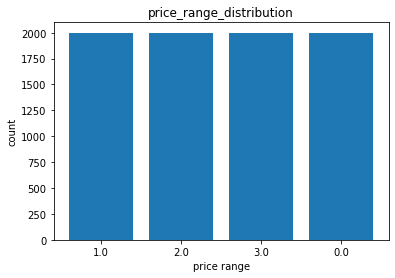

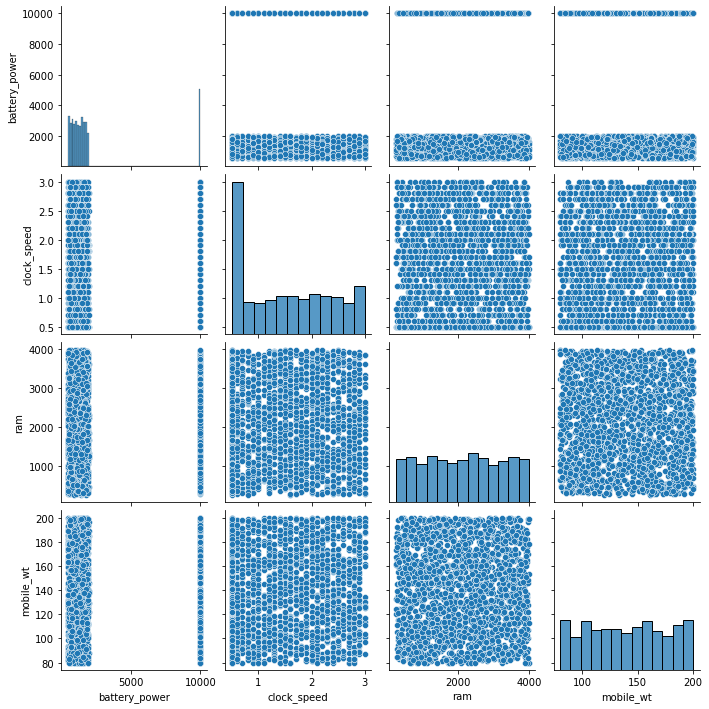

In [45]:
with mlflow.start_run(run_name='EDA',experiment_id = experiment_id) as run:
    plt.bar(x = dirty.price_range.astype('str'), height = dirty.price_range.count())
    plt.title('price_range_distribution')
    plt.xlabel('price range')
    plt.ylabel('count')
    plt.savefig("target.png")
    mlflow.log_artifact('target.png') 
    
    sns_plot = sns.pairplot(dirty[['battery_power','clock_speed','ram','mobile_wt']], size=2.5)
    fig = sns_plot.savefig("pairplot.png")
    mlflow.log_artifact('pairplot.png') 

## Models

/Applications/anaconda3/lib/python3.8/site-packages/seaborn/axisgrid.py:1969: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


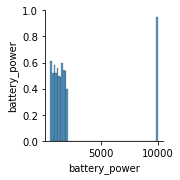

In [13]:
# Functions to compute True Positives, True Negatives, False Positives and False Negatives
def true_positive(y_true, y_pred):    
    tp = 0
    
    for yt, yp in zip(y_true, y_pred):
        
        if yt == 1 and yp == 1:
            tp += 1
    
    return tp
def true_negative(y_true, y_pred):    
    tn = 0
    
    for yt, yp in zip(y_true, y_pred):
        
        if yt == 0 and yp == 0:
            tn += 1
            
    return tn

def false_positive(y_true, y_pred):   
    fp = 0
    
    for yt, yp in zip(y_true, y_pred):
        
        if yt == 0 and yp == 1:
            fp += 1
            
    return fp

def false_negative(y_true, y_pred):
    
    fn = 0
    
    for yt, yp in zip(y_true, y_pred):
        
        if yt == 1 and yp == 0:
            fn += 1
            
    return fn

#Computation of macro-averaged precision

def macro_precision(y_true, y_pred):

    # find the number of classes
    num_classes = len(np.unique(y_true))

    # initialize precision to 0
    precision = 0
    
    # loop over all classes
    for class_ in list(y_true.unique()):
        
        # all classes except current are considered negative
        temp_true = [1 if p == class_ else 0 for p in y_true]
        temp_pred = [1 if p == class_ else 0 for p in y_pred]
        
        
        # compute true positive for current class
        tp = true_positive(temp_true, temp_pred)
        
        # compute false positive for current class
        fp = false_positive(temp_true, temp_pred)
        
        
        # compute precision for current class
        temp_precision = tp / (tp + fp + 1e-6)
        # keep adding precision for all classes
        precision += temp_precision
        
    # calculate and return average precision over all classes
    precision /= num_classes
    
    return precision

In [14]:
#Computation of macro-averaged fi score

def macro_f1(y_true, y_pred):

    # find the number of classes
    num_classes = len(np.unique(y_true))

    # initialize f1 to 0
    f1 = 0
    
    # loop over all classes
    for class_ in list(y_true.unique()):
        
        # all classes except current are considered negative
        temp_true = [1 if p == class_ else 0 for p in y_true]
        temp_pred = [1 if p == class_ else 0 for p in y_pred]
        
        
        # compute true positive for current class
        tp = true_positive(temp_true, temp_pred)
        
        # compute false negative for current class
        fn = false_negative(temp_true, temp_pred)
        
        # compute false positive for current class
        fp = false_positive(temp_true, temp_pred)
        
        
        # compute recall for current class
        temp_recall = tp / (tp + fn + 1e-6)
        
        # compute precision for current class
        temp_precision = tp / (tp + fp + 1e-6)
        
        
        temp_f1 = 2 * temp_precision * temp_recall / (temp_precision + temp_recall + 1e-6)
        
        # keep adding f1 score for all classes
        f1 += temp_f1
        
    # calculate and return average f1 score over all classes
    f1 /= num_classes
    
    return f1

In [15]:
#Computation of macro-averaged recall

def macro_recall(y_true, y_pred):

    # find the number of classes
    num_classes = len(np.unique(y_true))

    # initialize recall to 0
    recall = 0
    
    # loop over all classes
    for class_ in list(y_true.unique()):
        
        # all classes except current are considered negative
        temp_true = [1 if p == class_ else 0 for p in y_true]
        temp_pred = [1 if p == class_ else 0 for p in y_pred]
        
        
        # compute true positive for current class
        tp = true_positive(temp_true, temp_pred)
        
        # compute false negative for current class
        fn = false_negative(temp_true, temp_pred)
        
        
        # compute recall for current class
        temp_recall = tp / (tp + fn + 1e-6)
        
        # keep adding recall for all classes
        recall += temp_recall
        
    # calculate and return average recall over all classes
    recall /= num_classes
    
    return recall

In [16]:
from sklearn.metrics import roc_auc_score
def roc_auc_score_multiclass(actual_class, pred_class, average = "macro"):
    
    #creating a set of all the unique classes using the actual class list
    unique_class = set(actual_class)
    roc_auc_dict = {}
    for per_class in unique_class:
        
        #creating a list of all the classes except the current class 
        other_class = [x for x in unique_class if x != per_class]

        #marking the current class as 1 and all other classes as 0
        new_actual_class = [0 if x in other_class else 1 for x in actual_class]
        new_pred_class = [0 if x in other_class else 1 for x in pred_class]

        #using the sklearn metrics method to calculate the roc_auc_score
        roc_auc = roc_auc_score(new_actual_class, new_pred_class, average = average)
        roc_auc_dict[per_class] = roc_auc

    return roc_auc_dict

In [20]:
with mlflow.start_run(run_name='random_forest',experiment_id = experiment_id) as run:
  n_estimators = 100
  max_depth = 6
  max_features = 3
  # Create and train model
  rf = sklearn.ensemble.RandomForestClassifier(n_estimators = n_estimators, max_depth = max_depth, max_features = max_features)
  rf.fit(X_train, y_train)
  # Make predictions
  predictions = rf.predict(X_test)
  predicted_probs = rf.predict_proba(X_test)
  # Log parameters
  mlflow.log_param("num_trees", n_estimators)
  mlflow.log_param("maxdepth", max_depth)
  mlflow.log_param("max_feat", max_features)
  # Log model
  mlflow.sklearn.log_model(rf, "random-forest-model")
  # Log metrics
  accuracy = sklearn.metrics.accuracy_score(y_test, predictions)
  mlflow.log_metric("accuracy", accuracy)
  print("Test Accuracy of: {}".format(accuracy)) 
  precision = macro_precision(y_test, predictions)
  mlflow.log_metric("precision", precision)
  print("Test Precision of: {}".format(precision)) 
  recall = macro_recall(y_test, predictions)
  mlflow.log_metric("recall", recall)
  print("Test Recall of: {}".format(recall)) 
  f1 = macro_f1(y_test, predictions)
  mlflow.log_metric("f1", f1)
  print("Test Recall of: {}".format(f1)) 
  #roc = roc_auc_score_multiclass(y_test, predictions)
  #mlflow.log_metric("test_auc", roc)
  #print("Test ROC_AUC of: {}".format(roc)) 

2021/11/01 01:44:41 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/Applications/anaconda3/lib/python3.8/site-packages/mlflow/models/signature.py:129: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details."


Test Accuracy of: 0.8016666666666666
Test Precision of: 0.7945094399670987
Test Recall of: 0.7981368570108046
Test Recall of: 0.7981368570108046


In [21]:
with mlflow.start_run(run_name='gradient_boost',experiment_id = experiment_id) as run:
  n_estimators = 100
  learning_rate = 0.1
  max_depth = 3
  # Create and train model
  gb = sklearn.ensemble.GradientBoostingClassifier(n_estimators = n_estimators, max_depth = max_depth, learning_rate = learning_rate)
  gb.fit(X_train, y_train)
  # Make predictions
  predictions = gb.predict(X_test)
  predicted_probs = gb.predict_proba(X_test)
  # Log parameters
  mlflow.log_param("num_trees", n_estimators)
  mlflow.log_param("maxdepth", max_depth)
  mlflow.log_param("max_feat", max_features)
  # Log model
  mlflow.sklearn.log_model(gb, "random-forest-model")
  # Log metrics
  accuracy = sklearn.metrics.accuracy_score(y_test, predictions)
  mlflow.log_metric("accuracy", accuracy)
  print("Test Accuracy of: {}".format(accuracy)) 
  precision = macro_precision(y_test, predictions)
  mlflow.log_metric("precision", precision)
  print("Test Precision of: {}".format(precision)) 
  recall = macro_recall(y_test, predictions)
  mlflow.log_metric("recall", recall)
  print("Test Recall of: {}".format(recall)) 
  f1 = macro_f1(y_test, predictions)
  mlflow.log_metric("f1", f1)
  print("Test Recall of: {}".format(f1)) 
  #roc = roc_auc_score_multiclass(y_test, predictions)
  #mlflow.log_metric("test_auc", roc)
  #print("Test ROC_AUC of: {}".format(roc)) 

2021/11/01 01:46:58 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/Applications/anaconda3/lib/python3.8/site-packages/mlflow/models/signature.py:129: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details."


Test Accuracy of: 0.8866666666666667
Test Precision of: 0.8851337464939835
Test Recall of: 0.8858621777123431
Test Recall of: 0.8858621777123431


## Hyperparameter tuning in gradient boosting model

In [29]:

search_space = {
  'n_estimators': scope.int(hp.quniform('n_estimators', 20, 1000, 1)),
  'learning_rate': hp.loguniform('learning_rate', -3, 0),
  'max_depth': scope.int(hp.quniform('max_depth', 2, 5, 1)),
}

def train_model(params):
  mlflow.autolog()
  # Enable autologging on each worker
  with mlflow.start_run(nested=True,experiment_id = experiment_id):
    model_hp = sklearn.ensemble.GradientBoostingClassifier(
      random_state=0,
      **params)
    model_hp.fit(X_train, y_train)
    predicted_probs = model_hp.predict_proba(X_test)
    predictions = gb.predict(X_test)
    f1 = macro_f1(y_test, predictions)
    mlflow.log_metric('test_f1', f1)
    mlflow.log_metric("accuracy", accuracy)
    precision = macro_precision(y_test, predictions)
    mlflow.log_metric("precision", precision)
    recall = macro_recall(y_test, predictions)
    mlflow.log_metric("recall", recall)
    return {'status': STATUS_OK, 'loss': -1*f1}

    
with mlflow.start_run(run_name='gb_hyperopt',experiment_id = experiment_id) as run:
  # Use hyperopt to find the parameters yielding the highest f1 score
  best_params = fmin(
    fn=train_model, 
    space=search_space, 
    algo=tpe.suggest, 
    max_evals=32)


  0%|          | 0/32 [00:00<?, ?trial/s, best loss=?]

2021/11/01 01:59:16 INFO mlflow.tracking.fluent: Autologging successfully enabled for pyspark.

2021/11/01 01:59:16 INFO mlflow.pyspark.ml: No SparkSession detected. Autologging will log pyspark.ml models contained in the default allowlist. To specify a custom allowlist, initialize a SparkSession prior to calling mlflow.pyspark.ml.autolog() and specify the path to your allowlist file via the spark.mlflow.pysparkml.autolog.logModelAllowlistFile conf.

2021/11/01 01:59:16 INFO mlflow.tracking.fluent: Autologging successfully enabled for pyspark.ml.

2021/11/01 01:59:27 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/Applications/anaconda3/lib/python3.8/site-packages/mlflow/models/signature.py:129: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The

  3%|▎         | 1/32 [00:21<11:04, 21.43s/trial, best loss: -0.885179430140286]

2021/11/01 01:59:38 INFO mlflow.tracking.fluent: Autologging successfully enabled for pyspark.

2021/11/01 01:59:38 INFO mlflow.pyspark.ml: No SparkSession detected. Autologging will log pyspark.ml models contained in the default allowlist. To specify a custom allowlist, initialize a SparkSession prior to calling mlflow.pyspark.ml.autolog() and specify the path to your allowlist file via the spark.mlflow.pysparkml.autolog.logModelAllowlistFile conf.

2021/11/01 01:59:38 INFO mlflow.tracking.fluent: Autologging successfully enabled for pyspark.ml.

2021/11/01 01:59:49 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/Applications/anaconda3/lib/python3.8/site-packages/mlflow/models/signature.py:129: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The

  6%|▋         | 2/32 [00:42<10:42, 21.40s/trial, best loss: -0.885179430140286]

2021/11/01 01:59:59 INFO mlflow.tracking.fluent: Autologging successfully enabled for pyspark.

2021/11/01 01:59:59 INFO mlflow.pyspark.ml: No SparkSession detected. Autologging will log pyspark.ml models contained in the default allowlist. To specify a custom allowlist, initialize a SparkSession prior to calling mlflow.pyspark.ml.autolog() and specify the path to your allowlist file via the spark.mlflow.pysparkml.autolog.logModelAllowlistFile conf.

2021/11/01 01:59:59 INFO mlflow.tracking.fluent: Autologging successfully enabled for pyspark.ml.

2021/11/01 02:00:18 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/Applications/anaconda3/lib/python3.8/site-packages/mlflow/models/signature.py:129: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The

  9%|▉         | 3/32 [01:15<11:58, 24.77s/trial, best loss: -0.885179430140286]

2021/11/01 02:00:32 INFO mlflow.tracking.fluent: Autologging successfully enabled for pyspark.

2021/11/01 02:00:32 INFO mlflow.pyspark.ml: No SparkSession detected. Autologging will log pyspark.ml models contained in the default allowlist. To specify a custom allowlist, initialize a SparkSession prior to calling mlflow.pyspark.ml.autolog() and specify the path to your allowlist file via the spark.mlflow.pysparkml.autolog.logModelAllowlistFile conf.

2021/11/01 02:00:32 INFO mlflow.tracking.fluent: Autologging successfully enabled for pyspark.ml.

2021/11/01 02:00:37 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/Applications/anaconda3/lib/python3.8/site-packages/mlflow/models/signature.py:129: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The

 12%|█▎        | 4/32 [01:29<10:00, 21.43s/trial, best loss: -0.885179430140286]

2021/11/01 02:00:45 INFO mlflow.tracking.fluent: Autologging successfully enabled for pyspark.

2021/11/01 02:00:45 INFO mlflow.pyspark.ml: No SparkSession detected. Autologging will log pyspark.ml models contained in the default allowlist. To specify a custom allowlist, initialize a SparkSession prior to calling mlflow.pyspark.ml.autolog() and specify the path to your allowlist file via the spark.mlflow.pysparkml.autolog.logModelAllowlistFile conf.

2021/11/01 02:00:45 INFO mlflow.tracking.fluent: Autologging successfully enabled for pyspark.ml.

2021/11/01 02:00:52 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/Applications/anaconda3/lib/python3.8/site-packages/mlflow/models/signature.py:129: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The

 16%|█▌        | 5/32 [01:45<08:56, 19.88s/trial, best loss: -0.885179430140286]

2021/11/01 02:01:02 INFO mlflow.tracking.fluent: Autologging successfully enabled for pyspark.

2021/11/01 02:01:02 INFO mlflow.pyspark.ml: No SparkSession detected. Autologging will log pyspark.ml models contained in the default allowlist. To specify a custom allowlist, initialize a SparkSession prior to calling mlflow.pyspark.ml.autolog() and specify the path to your allowlist file via the spark.mlflow.pysparkml.autolog.logModelAllowlistFile conf.

2021/11/01 02:01:02 INFO mlflow.tracking.fluent: Autologging successfully enabled for pyspark.ml.

2021/11/01 02:01:11 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/Applications/anaconda3/lib/python3.8/site-packages/mlflow/models/signature.py:129: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The

 19%|█▉        | 6/32 [02:06<08:45, 20.22s/trial, best loss: -0.885179430140286]

2021/11/01 02:01:23 INFO mlflow.tracking.fluent: Autologging successfully enabled for pyspark.

2021/11/01 02:01:23 INFO mlflow.pyspark.ml: No SparkSession detected. Autologging will log pyspark.ml models contained in the default allowlist. To specify a custom allowlist, initialize a SparkSession prior to calling mlflow.pyspark.ml.autolog() and specify the path to your allowlist file via the spark.mlflow.pysparkml.autolog.logModelAllowlistFile conf.

2021/11/01 02:01:23 INFO mlflow.tracking.fluent: Autologging successfully enabled for pyspark.ml.

2021/11/01 02:01:31 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/Applications/anaconda3/lib/python3.8/site-packages/mlflow/models/signature.py:129: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The

 22%|██▏       | 7/32 [02:23<07:58, 19.16s/trial, best loss: -0.885179430140286]

2021/11/01 02:01:39 INFO mlflow.tracking.fluent: Autologging successfully enabled for pyspark.

2021/11/01 02:01:39 INFO mlflow.pyspark.ml: No SparkSession detected. Autologging will log pyspark.ml models contained in the default allowlist. To specify a custom allowlist, initialize a SparkSession prior to calling mlflow.pyspark.ml.autolog() and specify the path to your allowlist file via the spark.mlflow.pysparkml.autolog.logModelAllowlistFile conf.

2021/11/01 02:01:39 INFO mlflow.tracking.fluent: Autologging successfully enabled for pyspark.ml.

2021/11/01 02:01:59 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/Applications/anaconda3/lib/python3.8/site-packages/mlflow/models/signature.py:129: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The

 25%|██▌       | 8/32 [02:54<09:10, 22.94s/trial, best loss: -0.885179430140286]

2021/11/01 02:02:11 INFO mlflow.tracking.fluent: Autologging successfully enabled for pyspark.

2021/11/01 02:02:11 INFO mlflow.pyspark.ml: No SparkSession detected. Autologging will log pyspark.ml models contained in the default allowlist. To specify a custom allowlist, initialize a SparkSession prior to calling mlflow.pyspark.ml.autolog() and specify the path to your allowlist file via the spark.mlflow.pysparkml.autolog.logModelAllowlistFile conf.

2021/11/01 02:02:11 INFO mlflow.tracking.fluent: Autologging successfully enabled for pyspark.ml.

2021/11/01 02:02:14 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/Applications/anaconda3/lib/python3.8/site-packages/mlflow/models/signature.py:129: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The

 28%|██▊       | 9/32 [03:03<07:11, 18.74s/trial, best loss: -0.885179430140286]

2021/11/01 02:02:20 INFO mlflow.tracking.fluent: Autologging successfully enabled for pyspark.

2021/11/01 02:02:20 INFO mlflow.pyspark.ml: No SparkSession detected. Autologging will log pyspark.ml models contained in the default allowlist. To specify a custom allowlist, initialize a SparkSession prior to calling mlflow.pyspark.ml.autolog() and specify the path to your allowlist file via the spark.mlflow.pysparkml.autolog.logModelAllowlistFile conf.

2021/11/01 02:02:20 INFO mlflow.tracking.fluent: Autologging successfully enabled for pyspark.ml.

2021/11/01 02:02:24 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/Applications/anaconda3/lib/python3.8/site-packages/mlflow/models/signature.py:129: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The

 31%|███▏      | 10/32 [03:14<06:02, 16.49s/trial, best loss: -0.885179430140286]

2021/11/01 02:02:31 INFO mlflow.tracking.fluent: Autologging successfully enabled for pyspark.

2021/11/01 02:02:31 INFO mlflow.pyspark.ml: No SparkSession detected. Autologging will log pyspark.ml models contained in the default allowlist. To specify a custom allowlist, initialize a SparkSession prior to calling mlflow.pyspark.ml.autolog() and specify the path to your allowlist file via the spark.mlflow.pysparkml.autolog.logModelAllowlistFile conf.

2021/11/01 02:02:31 INFO mlflow.tracking.fluent: Autologging successfully enabled for pyspark.ml.

2021/11/01 02:02:34 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/Applications/anaconda3/lib/python3.8/site-packages/mlflow/models/signature.py:129: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The

 34%|███▍      | 11/32 [03:25<05:11, 14.83s/trial, best loss: -0.885179430140286]

2021/11/01 02:02:42 INFO mlflow.tracking.fluent: Autologging successfully enabled for pyspark.

2021/11/01 02:02:42 INFO mlflow.pyspark.ml: No SparkSession detected. Autologging will log pyspark.ml models contained in the default allowlist. To specify a custom allowlist, initialize a SparkSession prior to calling mlflow.pyspark.ml.autolog() and specify the path to your allowlist file via the spark.mlflow.pysparkml.autolog.logModelAllowlistFile conf.

2021/11/01 02:02:42 INFO mlflow.tracking.fluent: Autologging successfully enabled for pyspark.ml.

2021/11/01 02:03:06 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/Applications/anaconda3/lib/python3.8/site-packages/mlflow/models/signature.py:129: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The

 38%|███▊      | 12/32 [04:09<07:47, 23.36s/trial, best loss: -0.885179430140286]

2021/11/01 02:03:25 INFO mlflow.tracking.fluent: Autologging successfully enabled for pyspark.

2021/11/01 02:03:25 INFO mlflow.pyspark.ml: No SparkSession detected. Autologging will log pyspark.ml models contained in the default allowlist. To specify a custom allowlist, initialize a SparkSession prior to calling mlflow.pyspark.ml.autolog() and specify the path to your allowlist file via the spark.mlflow.pysparkml.autolog.logModelAllowlistFile conf.

2021/11/01 02:03:25 INFO mlflow.tracking.fluent: Autologging successfully enabled for pyspark.ml.

2021/11/01 02:03:39 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/Applications/anaconda3/lib/python3.8/site-packages/mlflow/models/signature.py:129: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The

 41%|████      | 13/32 [04:33<07:28, 23.59s/trial, best loss: -0.885179430140286]

2021/11/01 02:03:50 INFO mlflow.tracking.fluent: Autologging successfully enabled for pyspark.

2021/11/01 02:03:50 INFO mlflow.pyspark.ml: No SparkSession detected. Autologging will log pyspark.ml models contained in the default allowlist. To specify a custom allowlist, initialize a SparkSession prior to calling mlflow.pyspark.ml.autolog() and specify the path to your allowlist file via the spark.mlflow.pysparkml.autolog.logModelAllowlistFile conf.

2021/11/01 02:03:50 INFO mlflow.tracking.fluent: Autologging successfully enabled for pyspark.ml.

2021/11/01 02:04:01 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/Applications/anaconda3/lib/python3.8/site-packages/mlflow/models/signature.py:129: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The

 44%|████▍     | 14/32 [04:53<06:47, 22.64s/trial, best loss: -0.885179430140286]

2021/11/01 02:04:10 INFO mlflow.tracking.fluent: Autologging successfully enabled for pyspark.

2021/11/01 02:04:10 INFO mlflow.pyspark.ml: No SparkSession detected. Autologging will log pyspark.ml models contained in the default allowlist. To specify a custom allowlist, initialize a SparkSession prior to calling mlflow.pyspark.ml.autolog() and specify the path to your allowlist file via the spark.mlflow.pysparkml.autolog.logModelAllowlistFile conf.

2021/11/01 02:04:10 INFO mlflow.tracking.fluent: Autologging successfully enabled for pyspark.ml.

2021/11/01 02:04:19 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/Applications/anaconda3/lib/python3.8/site-packages/mlflow/models/signature.py:129: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The

 47%|████▋     | 15/32 [05:12<06:07, 21.63s/trial, best loss: -0.885179430140286]

2021/11/01 02:04:29 INFO mlflow.tracking.fluent: Autologging successfully enabled for pyspark.

2021/11/01 02:04:29 INFO mlflow.pyspark.ml: No SparkSession detected. Autologging will log pyspark.ml models contained in the default allowlist. To specify a custom allowlist, initialize a SparkSession prior to calling mlflow.pyspark.ml.autolog() and specify the path to your allowlist file via the spark.mlflow.pysparkml.autolog.logModelAllowlistFile conf.

2021/11/01 02:04:29 INFO mlflow.tracking.fluent: Autologging successfully enabled for pyspark.ml.

2021/11/01 02:04:44 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/Applications/anaconda3/lib/python3.8/site-packages/mlflow/models/signature.py:129: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The

 50%|█████     | 16/32 [05:40<06:15, 23.48s/trial, best loss: -0.885179430140286]

2021/11/01 02:04:57 INFO mlflow.tracking.fluent: Autologging successfully enabled for pyspark.

2021/11/01 02:04:57 INFO mlflow.pyspark.ml: No SparkSession detected. Autologging will log pyspark.ml models contained in the default allowlist. To specify a custom allowlist, initialize a SparkSession prior to calling mlflow.pyspark.ml.autolog() and specify the path to your allowlist file via the spark.mlflow.pysparkml.autolog.logModelAllowlistFile conf.

2021/11/01 02:04:57 INFO mlflow.tracking.fluent: Autologging successfully enabled for pyspark.ml.

2021/11/01 02:05:13 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/Applications/anaconda3/lib/python3.8/site-packages/mlflow/models/signature.py:129: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The

 53%|█████▎    | 17/32 [06:09<06:14, 24.94s/trial, best loss: -0.885179430140286]

2021/11/01 02:05:25 INFO mlflow.tracking.fluent: Autologging successfully enabled for pyspark.

2021/11/01 02:05:25 INFO mlflow.pyspark.ml: No SparkSession detected. Autologging will log pyspark.ml models contained in the default allowlist. To specify a custom allowlist, initialize a SparkSession prior to calling mlflow.pyspark.ml.autolog() and specify the path to your allowlist file via the spark.mlflow.pysparkml.autolog.logModelAllowlistFile conf.

2021/11/01 02:05:25 INFO mlflow.tracking.fluent: Autologging successfully enabled for pyspark.ml.

2021/11/01 02:05:37 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/Applications/anaconda3/lib/python3.8/site-packages/mlflow/models/signature.py:129: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The

 56%|█████▋    | 18/32 [06:30<05:33, 23.79s/trial, best loss: -0.885179430140286]

2021/11/01 02:05:46 INFO mlflow.tracking.fluent: Autologging successfully enabled for pyspark.

2021/11/01 02:05:46 INFO mlflow.pyspark.ml: No SparkSession detected. Autologging will log pyspark.ml models contained in the default allowlist. To specify a custom allowlist, initialize a SparkSession prior to calling mlflow.pyspark.ml.autolog() and specify the path to your allowlist file via the spark.mlflow.pysparkml.autolog.logModelAllowlistFile conf.

2021/11/01 02:05:46 INFO mlflow.tracking.fluent: Autologging successfully enabled for pyspark.ml.

2021/11/01 02:05:50 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/Applications/anaconda3/lib/python3.8/site-packages/mlflow/models/signature.py:129: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The

 59%|█████▉    | 19/32 [06:41<04:19, 19.96s/trial, best loss: -0.885179430140286]

2021/11/01 02:05:57 INFO mlflow.tracking.fluent: Autologging successfully enabled for pyspark.

2021/11/01 02:05:57 INFO mlflow.pyspark.ml: No SparkSession detected. Autologging will log pyspark.ml models contained in the default allowlist. To specify a custom allowlist, initialize a SparkSession prior to calling mlflow.pyspark.ml.autolog() and specify the path to your allowlist file via the spark.mlflow.pysparkml.autolog.logModelAllowlistFile conf.

2021/11/01 02:05:57 INFO mlflow.tracking.fluent: Autologging successfully enabled for pyspark.ml.

2021/11/01 02:06:14 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/Applications/anaconda3/lib/python3.8/site-packages/mlflow/models/signature.py:129: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The

 62%|██████▎   | 20/32 [07:10<04:34, 22.84s/trial, best loss: -0.885179430140286]

2021/11/01 02:06:27 INFO mlflow.tracking.fluent: Autologging successfully enabled for pyspark.

2021/11/01 02:06:27 INFO mlflow.pyspark.ml: No SparkSession detected. Autologging will log pyspark.ml models contained in the default allowlist. To specify a custom allowlist, initialize a SparkSession prior to calling mlflow.pyspark.ml.autolog() and specify the path to your allowlist file via the spark.mlflow.pysparkml.autolog.logModelAllowlistFile conf.

2021/11/01 02:06:27 INFO mlflow.tracking.fluent: Autologging successfully enabled for pyspark.ml.

2021/11/01 02:06:47 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/Applications/anaconda3/lib/python3.8/site-packages/mlflow/models/signature.py:129: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The

 66%|██████▌   | 21/32 [07:42<04:40, 25.50s/trial, best loss: -0.885179430140286]

2021/11/01 02:06:59 INFO mlflow.tracking.fluent: Autologging successfully enabled for pyspark.

2021/11/01 02:06:59 INFO mlflow.pyspark.ml: No SparkSession detected. Autologging will log pyspark.ml models contained in the default allowlist. To specify a custom allowlist, initialize a SparkSession prior to calling mlflow.pyspark.ml.autolog() and specify the path to your allowlist file via the spark.mlflow.pysparkml.autolog.logModelAllowlistFile conf.

2021/11/01 02:06:59 INFO mlflow.tracking.fluent: Autologging successfully enabled for pyspark.ml.

2021/11/01 02:07:07 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/Applications/anaconda3/lib/python3.8/site-packages/mlflow/models/signature.py:129: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The

 69%|██████▉   | 22/32 [07:59<03:49, 22.99s/trial, best loss: -0.885179430140286]

2021/11/01 02:07:16 INFO mlflow.tracking.fluent: Autologging successfully enabled for pyspark.

2021/11/01 02:07:16 INFO mlflow.pyspark.ml: No SparkSession detected. Autologging will log pyspark.ml models contained in the default allowlist. To specify a custom allowlist, initialize a SparkSession prior to calling mlflow.pyspark.ml.autolog() and specify the path to your allowlist file via the spark.mlflow.pysparkml.autolog.logModelAllowlistFile conf.

2021/11/01 02:07:16 INFO mlflow.tracking.fluent: Autologging successfully enabled for pyspark.ml.

2021/11/01 02:07:24 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/Applications/anaconda3/lib/python3.8/site-packages/mlflow/models/signature.py:129: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The

 72%|███████▏  | 23/32 [08:17<03:13, 21.50s/trial, best loss: -0.885179430140286]

2021/11/01 02:07:34 INFO mlflow.tracking.fluent: Autologging successfully enabled for pyspark.

2021/11/01 02:07:34 INFO mlflow.pyspark.ml: No SparkSession detected. Autologging will log pyspark.ml models contained in the default allowlist. To specify a custom allowlist, initialize a SparkSession prior to calling mlflow.pyspark.ml.autolog() and specify the path to your allowlist file via the spark.mlflow.pysparkml.autolog.logModelAllowlistFile conf.

2021/11/01 02:07:34 INFO mlflow.tracking.fluent: Autologging successfully enabled for pyspark.ml.

2021/11/01 02:07:56 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/Applications/anaconda3/lib/python3.8/site-packages/mlflow/models/signature.py:129: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The

 75%|███████▌  | 24/32 [08:54<03:28, 26.03s/trial, best loss: -0.885179430140286]

2021/11/01 02:08:10 INFO mlflow.tracking.fluent: Autologging successfully enabled for pyspark.

2021/11/01 02:08:10 INFO mlflow.pyspark.ml: No SparkSession detected. Autologging will log pyspark.ml models contained in the default allowlist. To specify a custom allowlist, initialize a SparkSession prior to calling mlflow.pyspark.ml.autolog() and specify the path to your allowlist file via the spark.mlflow.pysparkml.autolog.logModelAllowlistFile conf.

2021/11/01 02:08:10 INFO mlflow.tracking.fluent: Autologging successfully enabled for pyspark.ml.

2021/11/01 02:08:20 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/Applications/anaconda3/lib/python3.8/site-packages/mlflow/models/signature.py:129: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The

 78%|███████▊  | 25/32 [09:12<02:46, 23.78s/trial, best loss: -0.885179430140286]

2021/11/01 02:08:29 INFO mlflow.tracking.fluent: Autologging successfully enabled for pyspark.

2021/11/01 02:08:29 INFO mlflow.pyspark.ml: No SparkSession detected. Autologging will log pyspark.ml models contained in the default allowlist. To specify a custom allowlist, initialize a SparkSession prior to calling mlflow.pyspark.ml.autolog() and specify the path to your allowlist file via the spark.mlflow.pysparkml.autolog.logModelAllowlistFile conf.

2021/11/01 02:08:29 INFO mlflow.tracking.fluent: Autologging successfully enabled for pyspark.ml.

2021/11/01 02:08:39 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/Applications/anaconda3/lib/python3.8/site-packages/mlflow/models/signature.py:129: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The

 81%|████████▏ | 26/32 [09:31<02:13, 22.19s/trial, best loss: -0.885179430140286]

2021/11/01 02:08:48 INFO mlflow.tracking.fluent: Autologging successfully enabled for pyspark.

2021/11/01 02:08:48 INFO mlflow.pyspark.ml: No SparkSession detected. Autologging will log pyspark.ml models contained in the default allowlist. To specify a custom allowlist, initialize a SparkSession prior to calling mlflow.pyspark.ml.autolog() and specify the path to your allowlist file via the spark.mlflow.pysparkml.autolog.logModelAllowlistFile conf.

2021/11/01 02:08:48 INFO mlflow.tracking.fluent: Autologging successfully enabled for pyspark.ml.

2021/11/01 02:09:04 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/Applications/anaconda3/lib/python3.8/site-packages/mlflow/models/signature.py:129: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The

 84%|████████▍ | 27/32 [09:59<01:59, 23.97s/trial, best loss: -0.885179430140286]

2021/11/01 02:09:16 INFO mlflow.tracking.fluent: Autologging successfully enabled for pyspark.

2021/11/01 02:09:16 INFO mlflow.pyspark.ml: No SparkSession detected. Autologging will log pyspark.ml models contained in the default allowlist. To specify a custom allowlist, initialize a SparkSession prior to calling mlflow.pyspark.ml.autolog() and specify the path to your allowlist file via the spark.mlflow.pysparkml.autolog.logModelAllowlistFile conf.

2021/11/01 02:09:16 INFO mlflow.tracking.fluent: Autologging successfully enabled for pyspark.ml.

2021/11/01 02:09:23 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/Applications/anaconda3/lib/python3.8/site-packages/mlflow/models/signature.py:129: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The

 88%|████████▊ | 28/32 [10:16<01:27, 21.83s/trial, best loss: -0.885179430140286]

2021/11/01 02:09:32 INFO mlflow.tracking.fluent: Autologging successfully enabled for pyspark.

2021/11/01 02:09:32 INFO mlflow.pyspark.ml: No SparkSession detected. Autologging will log pyspark.ml models contained in the default allowlist. To specify a custom allowlist, initialize a SparkSession prior to calling mlflow.pyspark.ml.autolog() and specify the path to your allowlist file via the spark.mlflow.pysparkml.autolog.logModelAllowlistFile conf.

2021/11/01 02:09:32 INFO mlflow.tracking.fluent: Autologging successfully enabled for pyspark.ml.

2021/11/01 02:09:44 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/Applications/anaconda3/lib/python3.8/site-packages/mlflow/models/signature.py:129: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The

 91%|█████████ | 29/32 [10:37<01:04, 21.54s/trial, best loss: -0.885179430140286]

2021/11/01 02:09:53 INFO mlflow.tracking.fluent: Autologging successfully enabled for pyspark.

2021/11/01 02:09:53 INFO mlflow.pyspark.ml: No SparkSession detected. Autologging will log pyspark.ml models contained in the default allowlist. To specify a custom allowlist, initialize a SparkSession prior to calling mlflow.pyspark.ml.autolog() and specify the path to your allowlist file via the spark.mlflow.pysparkml.autolog.logModelAllowlistFile conf.

2021/11/01 02:09:53 INFO mlflow.tracking.fluent: Autologging successfully enabled for pyspark.ml.

2021/11/01 02:10:06 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/Applications/anaconda3/lib/python3.8/site-packages/mlflow/models/signature.py:129: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The

 94%|█████████▍| 30/32 [10:59<00:43, 21.93s/trial, best loss: -0.885179430140286]

2021/11/01 02:10:16 INFO mlflow.tracking.fluent: Autologging successfully enabled for pyspark.

2021/11/01 02:10:16 INFO mlflow.pyspark.ml: No SparkSession detected. Autologging will log pyspark.ml models contained in the default allowlist. To specify a custom allowlist, initialize a SparkSession prior to calling mlflow.pyspark.ml.autolog() and specify the path to your allowlist file via the spark.mlflow.pysparkml.autolog.logModelAllowlistFile conf.

2021/11/01 02:10:16 INFO mlflow.tracking.fluent: Autologging successfully enabled for pyspark.ml.

2021/11/01 02:10:24 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/Applications/anaconda3/lib/python3.8/site-packages/mlflow/models/signature.py:129: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The

 97%|█████████▋| 31/32 [11:16<00:20, 20.22s/trial, best loss: -0.885179430140286]

2021/11/01 02:10:32 INFO mlflow.tracking.fluent: Autologging successfully enabled for pyspark.

2021/11/01 02:10:32 INFO mlflow.pyspark.ml: No SparkSession detected. Autologging will log pyspark.ml models contained in the default allowlist. To specify a custom allowlist, initialize a SparkSession prior to calling mlflow.pyspark.ml.autolog() and specify the path to your allowlist file via the spark.mlflow.pysparkml.autolog.logModelAllowlistFile conf.

2021/11/01 02:10:32 INFO mlflow.tracking.fluent: Autologging successfully enabled for pyspark.ml.

2021/11/01 02:10:40 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/Applications/anaconda3/lib/python3.8/site-packages/mlflow/models/signature.py:129: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The

100%|██████████| 32/32 [11:32<00:00, 21.65s/trial, best loss: -0.885179430140286]


## Retrive the best model

In [41]:
# best model and performance
runs = mlflow.search_runs(experiment_ids=experiment_id,
                          order_by=['metrics.test_f1'], max_results=1)
best_run = runs.loc[0]
best_run

run_id                                               0e85b2d0a4214214949ceca08328568b
experiment_id                                                        1018109468607158
status                                                                       FINISHED
artifact_uri                        dbfs:/databricks/mlflow-tracking/1018109468607...
start_time                                           2021-11-01 07:10:32.924000+00:00
end_time                                             2021-11-01 07:10:49.122000+00:00
metrics.training_recall_score                                                       1
metrics.recall                                                               0.885862
metrics.test_f1                                                              0.885179
metrics.precision                                                            0.885134
metrics.training_f1_score                                                           1
metrics.training_precision_score                      

## Deploy the best model 

In [42]:
best_model_pyfunc = mlflow.pyfunc.load_model(
      'runs:/{run_id}/model'.format(
        run_id=best_run.run_id))
best_model_predictions = pd.DataFrame(best_model_pyfunc.predict(X_test))
best_model_predictions.to_csv('prediction_result.csv')